In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd
from sympy import Symbol
from sympy.solvers import solve
import sympy as sp

In [2]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res


# Set experiment(s) to analyze


In [74]:
# Closed Loop dataset, excluding when AAS did not kick in
exp_ids=['2018_05_18_23_06_39_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance',
         '2018_05_18_23_24_49_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance',
         #'2018_05_18_23_43_47_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance', OP unlocked
         '2018_05_19_00_00_54_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance',
         '2018_05_19_00_19_37_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance',
         #'2018_05_19_00_37_59_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance',
         '2018_05_19_13_19_04_Closed loop with atom, Ramsey',
         '2018_05_19_13_46_16_Closed loop with atom, Ramsey',
         '2018_05_19_14_14_17_Closed loop with atom, Ramsey',
         '2018_05_19_14_39_45_Closed loop with atom, Ramsey'
         
        ]


In [75]:
assorted={}
assorted['qdp_class']=[]
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['qdp_class'].append(container['qdp_class'])
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_18/2018_05_18_23_06_39_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_18/2018_05_18_23_24_49_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_19/2018_05_19_00_00_54_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_19/2018_05_19_00_19_37_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_19/2018_05_19_13_19_04_Closed loop with atom, Ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_19/2018_05_19_13_46_16_Closed loop 

# Experiment-wise analysis

2018_05_18_23_06_39_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance
0


<IPython.core.display.Javascript object>


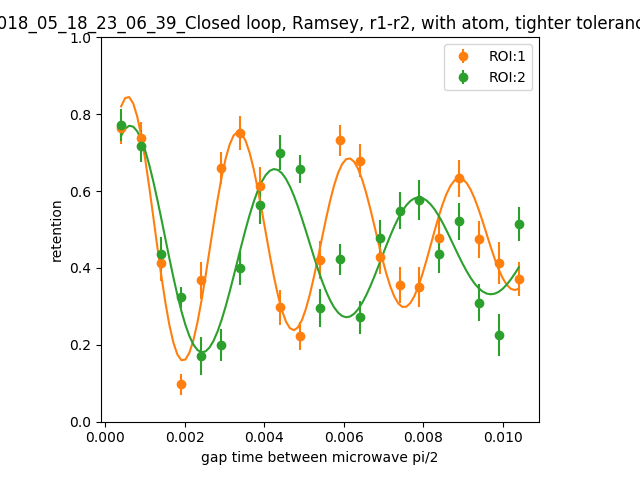

tau 1  is  0.0097168405268  with 1 std of   0.00201667044059
amplitude 1  is  0.390566770494  with 1 std of   0.0375164044002
frequency 1  is  359.668382649  with 1 std of   3.87319318898
phase 1  is  0.249144583528  with 1 std of   0.112362970221
offset 1  is  0.477776440255  with 1 std of   0.0107967485625
tau 2  is  0.00853075079691  with 1 std of   0.00333576023574
amplitude 2  is  0.351924024509  with 1 std of   0.0670881795905
frequency 2  is  275.748150053  with 1 std of   8.00576894765
phase 2  is  0.412884073557  with 1 std of   0.228557256287
offset 2  is  0.444181443476  with 1 std of   0.019083522372
2018_05_18_23_24_49_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance
1


<IPython.core.display.Javascript object>


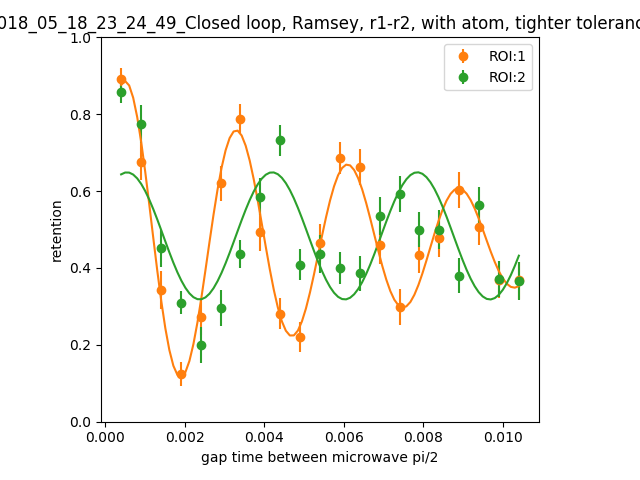

tau 1  is  0.00769057440206  with 1 std of   0.00097919520419
amplitude 1  is  0.448728676904  with 1 std of   0.030166482612
frequency 1  is  357.696466895  with 1 std of   3.03844829578
phase 1  is  0.395160074393  with 1 std of   0.0815251660595
offset 1  is  0.466317882101  with 1 std of   0.00830219784092
tau 2  is  -7.45014909656  with 1 std of   4149.70858047
amplitude 2  is  0.165320894688  with 1 std of   0.0737601743045
frequency 2  is  274.014131355  with 1 std of   12.4605081919
phase 2  is  0.627466257855  with 1 std of   0.496109640797
offset 2  is  0.483497846244  with 1 std of   0.0274084125587
2018_05_19_00_00_54_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance
2


<IPython.core.display.Javascript object>


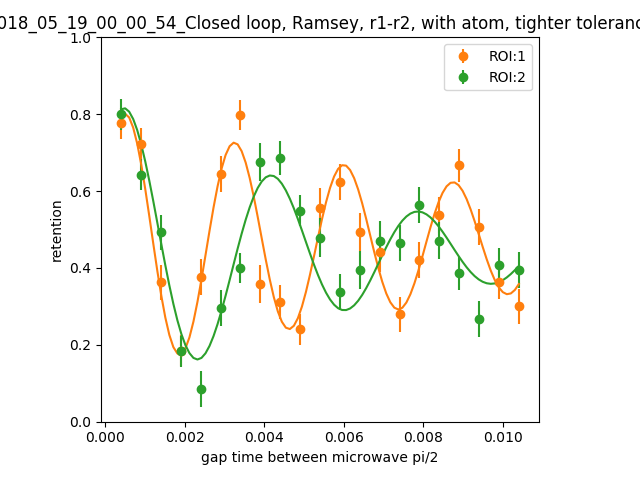

tau 1  is  0.0107919239695  with 1 std of   0.00332792074812
amplitude 1  is  0.348957380499  with 1 std of   0.0460107111671
frequency 1  is  363.684519456  with 1 std of   5.15290580669
phase 1  is  0.395757878329  with 1 std of   0.155277363099
offset 1  is  0.468088184268  with 1 std of   0.0136557507352
tau 2  is  0.00592855384463  with 1 std of   0.00143272647371
amplitude 2  is  0.410700190637  with 1 std of   0.0577967912482
frequency 2  is  270.844153976  with 1 std of   7.46833315139
phase 2  is  0.668705206381  with 1 std of   0.182575816064
offset 2  is  0.438315489815  with 1 std of   0.0151943927345
2018_05_19_00_19_37_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance
3


<IPython.core.display.Javascript object>


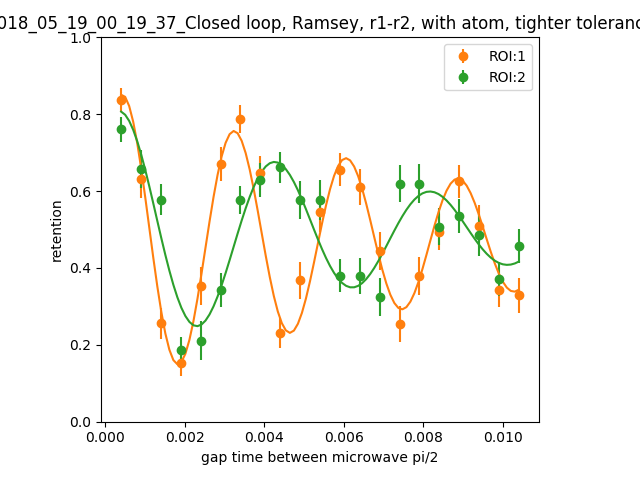

tau 1  is  0.00972391325583  with 1 std of   0.00220942893662
amplitude 1  is  0.393297367725  with 1 std of   0.0411656476508
frequency 1  is  355.224078499  with 1 std of   4.30676416121
phase 1  is  0.583557264727  with 1 std of   0.125364814551
offset 1  is  0.474809636696  with 1 std of   0.0119977090472
tau 2  is  0.00726468050202  with 1 std of   0.00228199864779
amplitude 2  is  0.333804803965  with 1 std of   0.0572662568301
frequency 2  is  256.145268313  with 1 std of   8.13436545216
phase 2  is  0.919896364768  with 1 std of   0.214481132322
offset 2  is  0.490753949487  with 1 std of   0.015707540819
2018_05_19_13_19_04_Closed loop with atom, Ramsey
4


<IPython.core.display.Javascript object>


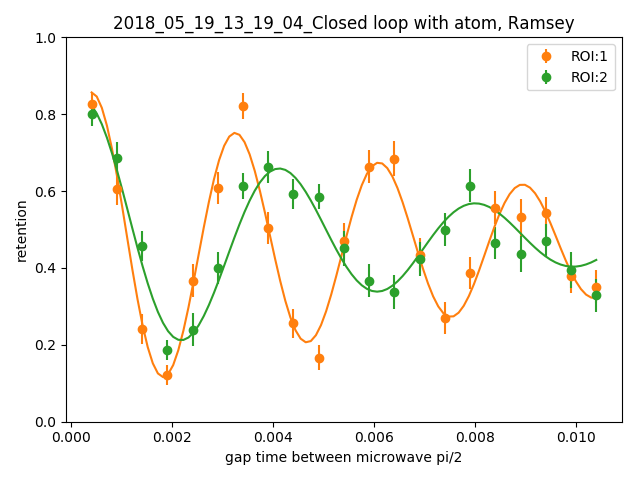

tau 1  is  0.00930439135462  with 1 std of   0.00171752496031
amplitude 1  is  0.416350130657  with 1 std of   0.036413480689
frequency 1  is  351.150038766  with 1 std of   3.64365319304
phase 1  is  0.648737332429  with 1 std of   0.104681346906
offset 1  is  0.458128357729  with 1 std of   0.0104839975408
tau 2  is  0.00584174431587  with 1 std of   0.00120898121829
amplitude 2  is  0.379594714755  with 1 std of   0.0479625713947
frequency 2  is  257.564426203  with 1 std of   6.47402031721
phase 2  is  1.08854369384  with 1 std of   0.153455622345
offset 2  is  0.472211470136  with 1 std of   0.0119405340858
2018_05_19_13_46_16_Closed loop with atom, Ramsey
5


<IPython.core.display.Javascript object>


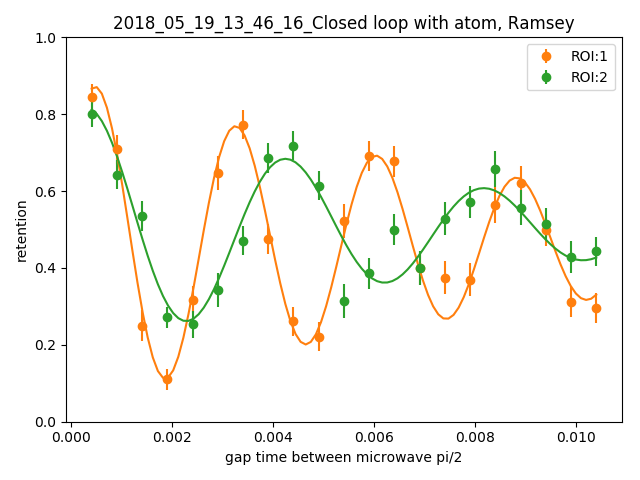

tau 1  is  0.00959875430947  with 1 std of   0.00146501505923
amplitude 1  is  0.427941581294  with 1 std of   0.0302686648231
frequency 1  is  359.431970638  with 1 std of   2.91537249272
phase 1  is  0.464598212803  with 1 std of   0.0846248836306
offset 1  is  0.464440606681  with 1 std of   0.00879824713029
tau 2  is  0.00727045944832  with 1 std of   0.00208991008005
amplitude 2  is  -0.328739249814  with 1 std of   0.0518901595998
frequency 2  is  254.492044047  with 1 std of   7.37812099952
phase 2  is  4.13016746814  with 1 std of   0.19408582617
offset 2  is  0.50122463135  with 1 std of   0.0140885132401
2018_05_19_14_14_17_Closed loop with atom, Ramsey
6


<IPython.core.display.Javascript object>


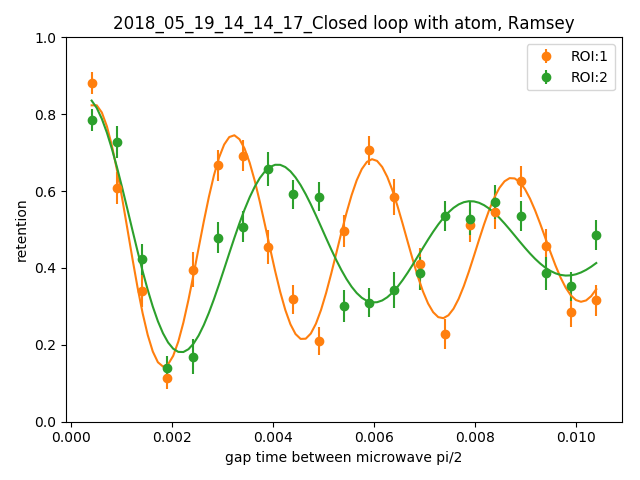

tau 1  is  0.0110406012292  with 1 std of   0.00271554446745
amplitude 1  is  0.377788672056  with 1 std of   0.0390509038687
frequency 1  is  362.61798636  with 1 std of   4.02019381782
phase 1  is  0.503158239735  with 1 std of   0.122040112523
offset 1  is  0.463177853084  with 1 std of   0.0116615282812
tau 2  is  0.00620133302746  with 1 std of   0.00144094277781
amplitude 2  is  0.401673535388  with 1 std of   0.0550753455314
frequency 2  is  261.485955011  with 1 std of   6.79328910118
phase 2  is  1.04635635796  with 1 std of   0.166689619163
offset 2  is  0.462165235697  with 1 std of   0.0140709764835
2018_05_19_14_39_45_Closed loop with atom, Ramsey
7


<IPython.core.display.Javascript object>


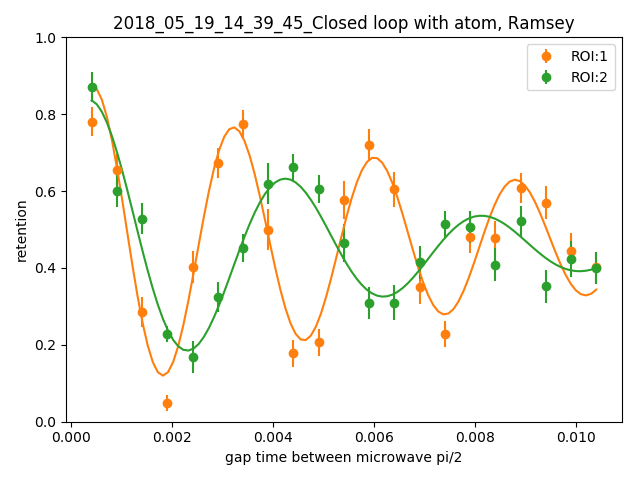

tau 1  is  0.00913826539205  with 1 std of   0.00227278319909
amplitude 1  is  0.424440468763  with 1 std of   0.0504160088271
frequency 1  is  358.119509437  with 1 std of   4.98634042482
phase 1  is  0.586566629392  with 1 std of   0.142518235167
offset 1  is  0.467633015538  with 1 std of   0.0144864837829
tau 2  is  0.00515538404452  with 1 std of   0.00103012147109
amplitude 2  is  0.417138004021  with 1 std of   0.0520519872204
frequency 2  is  257.352938681  with 1 std of   7.37963841665
phase 2  is  0.882505931889  with 1 std of   0.165642249386
offset 2  is  0.450313205372  with 1 std of   0.0129779148857


In [76]:
save_figures=False
data11 = []
for n in range(0,len(assorted['exp_ids'])):    
    print assorted['exp_ids'][n]
    assorted_roi3freqs=[]
    assorted_roi2freqs=[]
    assorted_roi3perr=[]
    assorted_roi2perr=[]
    i = n
    print i
    exp_id=assorted['exp_ids'][i]
    q=assorted['qdp_class'][i]
    q.experiments[0]['variable_list']
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    q.get_thresholds()
    retention = q.apply_thresholds()


    colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    fit_guesses=[0.016, 0.35, 350 ,1.3, 0.45]
    fit_guesses2=[0.016, 0.3, 450 ,1.3, 0.45]
    #roi_dependency=[0,0,0,0,0]
    fitted_parameters=[]
    freqarray = []
    for roi in [1,2]:
        error=0
        data = []
        reten = []
        err = []

        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
        #guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
        #try:
       # decaying_sin(t,tau,amp,freq,phase,offset)
        try:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offset',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

        except:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offsett',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

           #fit2,pcov2 = curve_fit(gaussian,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
       # except RuntimeError:
       #     error=1
    #     if error is not 1:
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit[0],fit[1],fit[2])
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit2[0],fit2[1],fit2[2])

        xarray=np.linspace(np.min(data),np.max(data),100)
        yfit=decaying_sin(xarray, fit[0], fit[1], fit[2], fit[3],fit[4])
        plt.plot(xarray,yfit,color=colors[roi])
           # yfit2=gaussian(xarray, fit2[0], fit2[1], fit2[2], fit2[3])
            #plt.plot(xarray,yfit,label="mj=5/2", color=colors[0])
            #plt.plot(xarray,yfit2,label="mj=3/2", color=colors[1])

    #         if roi==3:
    #             assorted_roi3freqs.append(fit[2])
    #             assorted_roi3perr.append(np.sqrt(pcov[2][2]))
    #         elif roi==2:
    #             assorted_roi2freqs.append(fit[2])
    #             assorted_roi2perr.append(np.sqrt(pcov[2][2]))

    ax.set_title(exp_id)
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.legend()
    plt.tight_layout()
    plt.show()
    if save_figures:
        plt.savefig('{}.pdf'.format(exp_id))
    
    
    
    starting_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][0])).strftime('%Y-%m-%d %H:%M:%S')
    end_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][len(assorted['timestamps'][i])-1])).strftime('%Y-%m-%d %H:%M:%S')
    middle_time = dt.datetime.fromtimestamp(int((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 )).strftime('%H:%M')
    time_length = (assorted['timestamps'][i][len(assorted['timestamps'][i])-1])-assorted['timestamps'][i][0]
    time_from_data_start = ((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 ) - assorted['timestamps'][0][0] 
    data11.append([ starting_time,end_time,freqarray[0],freqarray[1],freqarray[2],freqarray[3],middle_time,time_length,time_from_data_start])



<IPython.core.display.Javascript object>


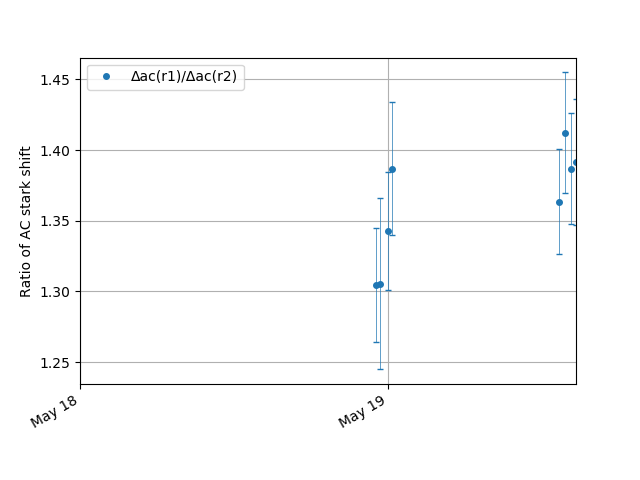

<IPython.core.display.Javascript object>


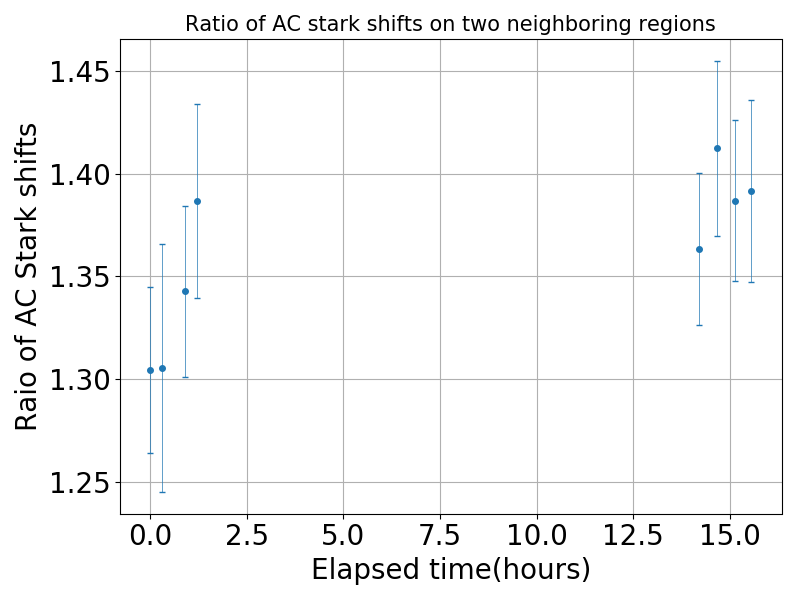

In [77]:
savefig=False
ratio_data=[]
ratio_error=[]
avetimestamp=[]
timelength=[]
startingtime=[]
startingtime_in_UNIX=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    startingtime_in_UNIX.append(assorted['timestamps'][i][0])
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])

#samplerate='2S'
#df=pd.DataFrame({  "Δac(r1)/Δac(r2)": ratio_data,'timestamps': avetimestamp,'error': ratio_error,'off_data': off_data},index=startingtime)
df=pd.DataFrame({  "Δac(r1)/Δac(r2)": ratio_data,'timestamps': avetimestamp,'error': ratio_error},index=startingtime)

ax=df.plot(y=[ "Δac(r1)/Δac(r2)"],yerr='error',capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',color=['#1f77b4', '#d62728'])
days=md.DayLocator()
hours=md.HourLocator()
ax.set_xlim(dt.datetime(2018,5,18))
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('Ratio of AC stark shift')
ax.grid()
#plt.savefig('Alignment_20180415.png')

timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
#ax.set_ylim(-0.3,0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='AC Stark shift ratios'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


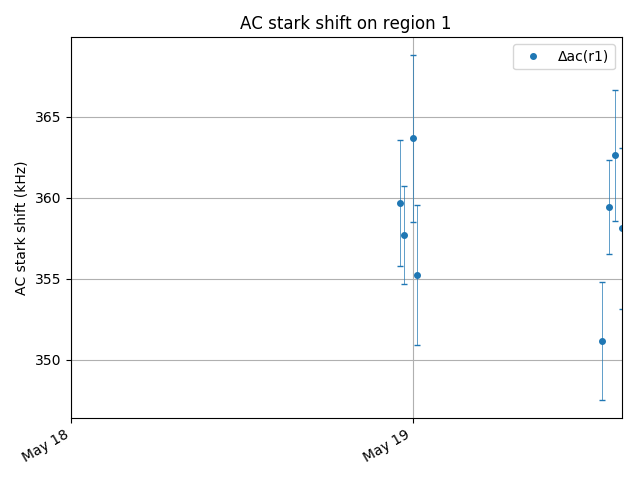

<IPython.core.display.Javascript object>


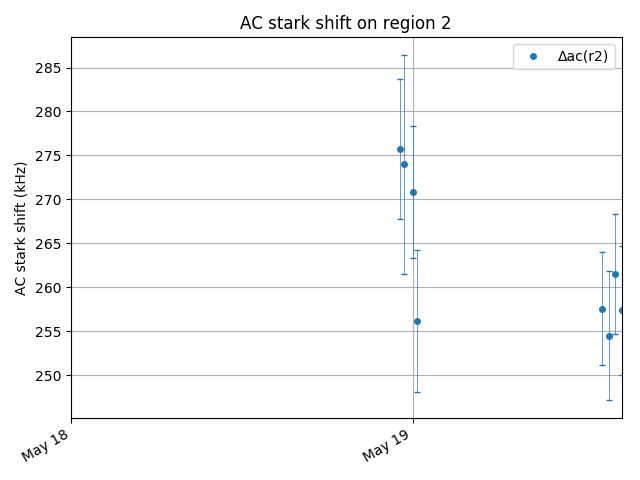

In [78]:

ROI1_ac=[]
ROI1_err=[]
ROI2_ac=[]
ROI2_err=[]
avetimestamp=[]
timelength=[]
startingtime=[]
ROI_err=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    ROI1_ac.append(data11[i][2])
    ROI_err.append([data11[i][3],data11[i][5]])
   # ROI_err.append(data11[i][3])
   # ROI_err.append(data11[i][5])
    ROI1_err.append(data11[i][3])
    ROI2_ac.append(data11[i][4])
    ROI2_err.append(data11[i][5])
    #ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])
 
# Using Pandas

df2=pd.DataFrame({  "Δac(r1)": ROI1_ac,'Δac(r2)':ROI2_ac,'timestamps': avetimestamp,'ROI_err': ROI_err},index=startingtime)

ax=df2.plot(y=[ "Δac(r1)"],yerr=ROI1_err,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
hours=md.HourLocator()
ax.set_xlim(dt.datetime(2018,5,18))
ax.xaxis.set_major_locator(days)
#ax.xaxis.set_minor_locator(hours)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('AC stark shift (kHz)')
ax.grid()
ax.set_title('AC stark shift on region 1')
plt.tight_layout()
if savefig:
    plt.savefig('r1_ac_starkshift.pdf')

ax2=df2.plot(y=[ "Δac(r2)"],yerr=ROI2_err,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
hours=md.HourLocator()
ax2.set_xlim(dt.datetime(2018,5,18))
ax2.xaxis.set_major_locator(days)
ax2.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax2.set_ylabel('AC stark shift')
ax2.grid()
ax2.set_ylabel('AC stark shift (kHz)')
ax2.set_title('AC stark shift on region 2')
plt.tight_layout()
if savefig:
    plt.savefig('r2_ac_starkshift.pdf')


In [107]:
ax.set_ylabel('AC stark shift (kHz)')
ax.grid()
ax.set_title('AC stark shift on region 1')
plt.tight_layout()
plt.savefig('r1_ac_starkshift')
# peakshift_r1 = 825.0
# peakshift_r2 = 825.0
# wx_r1 = 8.2
# wx_r2= 8.2
peakshift=825
wx=8.1
spacing = 9.25
xx = np.arange(-10.0, 10.0, 0.1)
# fig, ax = plt.subplots()
# plt.plot(xx,gaussian(xx,peakshift,-spacing/2,wx,0))
# plt.plot(xx,gaussian(xx,peakshift,spacing/2,wx,0))
# plt.show()

# fig, ax = plt.subplots()
# xxx = np.arange(-.3, 0.3, 0.005)
# plt.plot(xxx,(gaussian(xxx,peakshift,spacing/2,wx,0)/gaussian(xxx,peakshift,-spacing/2,wx,0)))
# plt.show()


In [116]:
def gaussian2(x,amp,x0,sigma,offset):
    res=(amp*sp.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res
#print gaussian(4,peakshift,spacing/2,wx,0)
#x=Symbol('x')
#print gaussian(y,peakshift,spacing/2,wx,0)
#print solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-1.1,x)


ratio_data=[]
ratio_error=[]
avetimestamp=[]
timelength=[]
startingtime=[]
avetimestamp=[]

for i in range(0,len(assorted['exp_ids'])):
#for i in [1]:
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])
#print error_total
ratio_to_dist=[]  
x=Symbol('x')
dist_max_error=[]
dist_min_error=[]
error_all=[]
for z in range(0,len(ratio_error)):
    print "doing {}-th fit.. out of {}".format(z,len(ratio_error))
    center_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z],x)
    max_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]-ratio_error[z],x)
    min_val =  solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]+ratio_error[z],x)
    ratio_to_dist.append(np.float(center_val[0]))
    maxerr = max_val[0] - center_val[0]
    minerr = center_val[0]- min_val[0]
    dist_max_error.append(np.float(maxerr))
    dist_min_error.append(np.float(minerr))
    error_all.append([np.float(maxerr),np.float(minerr)])

doing 0-th fit.. out of 92
doing 1-th fit.. out of 92
doing 2-th fit.. out of 92
doing 3-th fit.. out of 92
doing 4-th fit.. out of 92
doing 5-th fit.. out of 92
doing 6-th fit.. out of 92
doing 7-th fit.. out of 92
doing 8-th fit.. out of 92
doing 9-th fit.. out of 92
doing 10-th fit.. out of 92
doing 11-th fit.. out of 92
doing 12-th fit.. out of 92
doing 13-th fit.. out of 92
doing 14-th fit.. out of 92
doing 15-th fit.. out of 92
doing 16-th fit.. out of 92
doing 17-th fit.. out of 92
doing 18-th fit.. out of 92
doing 19-th fit.. out of 92
doing 20-th fit.. out of 92
doing 21-th fit.. out of 92
doing 22-th fit.. out of 92
doing 23-th fit.. out of 92
doing 24-th fit.. out of 92
doing 25-th fit.. out of 92
doing 26-th fit.. out of 92
doing 27-th fit.. out of 92
doing 28-th fit.. out of 92
doing 29-th fit.. out of 92
doing 30-th fit.. out of 92
doing 31-th fit.. out of 92
doing 32-th fit.. out of 92
doing 33-th fit.. out of 92
doing 34-th fit.. out of 92
doing 35-th fit.. out of 92
do

<IPython.core.display.Javascript object>


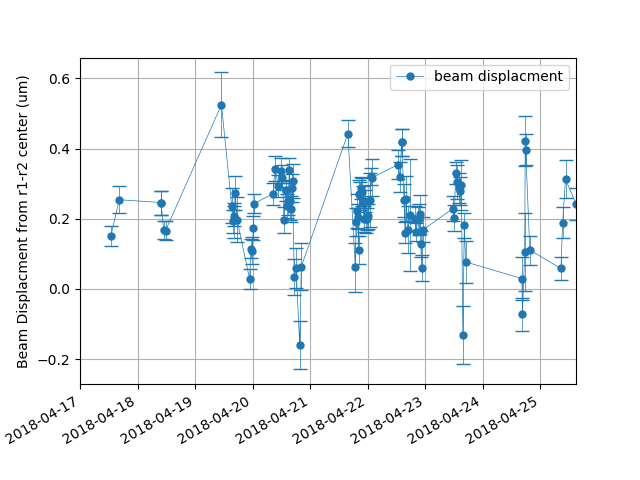

In [117]:
df4=pd.DataFrame({ "beam displacment": ratio_to_dist,'Max_error': dist_max_error,'Min_error': dist_min_error},index=startingtime)
ax=df4.plot(y=["beam displacment"],yerr=[dist_max_error,dist_min_error],capsize=5,lw=0.5,marker='o',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from r1-r2 center (um)')
ax.set_xlim(dt.datetime(2018,4,17))
ax.grid()

<IPython.core.display.Javascript object>


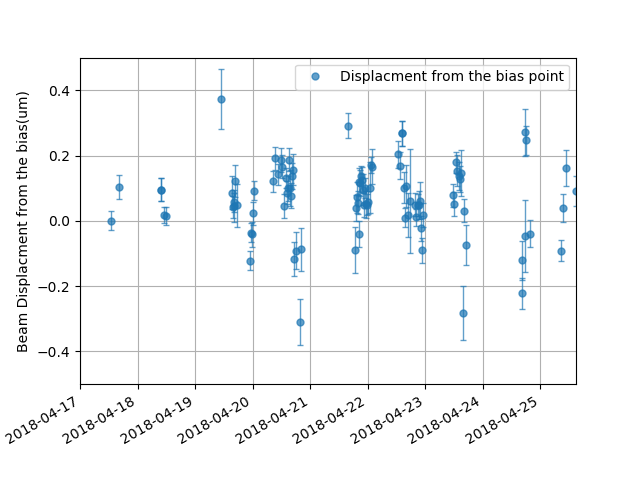

In [118]:
start_offset=np.mean(ratio_to_dist[0]) # Off
displacement_frombias=ratio_to_dist-start_offset
df5=pd.DataFrame({"Displacment from the bias point":displacement_frombias ,'Max_error': dist_max_error,'Min_error': dist_min_error},index=startingtime)
ax=df5.plot(y=["Displacment from the bias point"],yerr=[dist_max_error,dist_min_error],capsize=2,lw=1,marker='o',alpha=0.7,linestyle='None',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from the bias(um)')
ax.set_xlim(dt.datetime(2018,4,17))
ax.set_ylim(-0.5,0.5)
#days=md.DayLocator()
#ax.xaxis.set_major_locator(days)
#ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))

ax.grid()

<IPython.core.display.Javascript object>


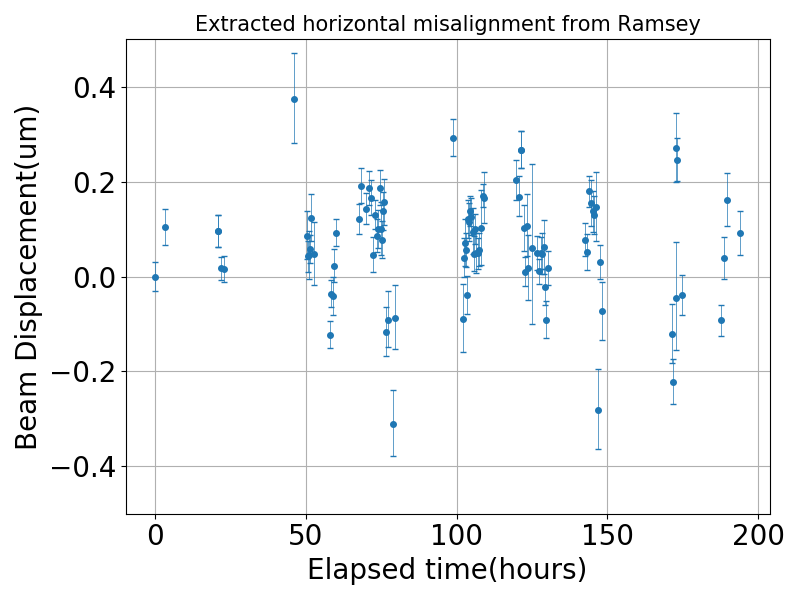

In [119]:
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Beam Displacement(um)',fontsize=20)
ax.set_title('Extracted horizontal misalignment from Ramsey',fontsize=15)
ax.set_ylim(-0.5,0.5)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Extracted_horizontal_misalignment_from_Ramsey'
# plt.savefig(filename+'.png')
# plt.savefig(filename+'.pdf')
# plt.savefig(filename+'.eps')

# TIME SERIES ANALYSES

In [79]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
         'AAS_redside',
         'AAS_blueside',
 'timestamp_measurements',
 'timestamp_iteration']

actuator_variables=['Red_X','Red_Y']

# exp_ids : This is list for Ramsey experiments.
# There are more experients with AAS on. Add them in this list
AAS_ids=[
        '2018_05_18_23_06_39_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance',
         '2018_05_18_23_24_49_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance',
         #'2018_05_18_23_43_47_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance', OP unlocked
         '2018_05_19_00_00_54_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance',
         '2018_05_19_00_19_37_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance',
         #'2018_05_19_00_37_59_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance',
        '2018_05_19_01_05_42_Closed loop without atom',
        '2018_05_19_08_48_56_Closed loop without atom',
         '2018_05_19_13_19_04_Closed loop with atom, Ramsey',
         '2018_05_19_13_46_16_Closed loop with atom, Ramsey',
         '2018_05_19_14_14_17_Closed loop with atom, Ramsey',
         '2018_05_19_14_39_45_Closed loop with atom, Ramsey'    
]

entire_closed_ids=exp_ids+AAS_ids


data={}
for j in range(0,len(entire_closed_ids)):
    exp_id=entire_closed_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)

        for var in actuator_variables:
            if i==0 and j==0:
                data[var]=[]
            try:
                data[var].append(q.experiments[e]['iterations'][i]['variables'][var])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, var)
                

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_18/2018_05_18_23_06_39_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_18/2018_05_18_23_24_49_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_19/2018_05_19_00_00_54_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_19/2018_05_19_00_19_37_Closed loop, Ramsey, r1-r2, with atom, tighter tolerance/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_19/2018_05_19_13_19_04_Closed loop with atom, Ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_19/2018_05_19_13_46_16_Closed loop 

<IPython.core.display.Javascript object>


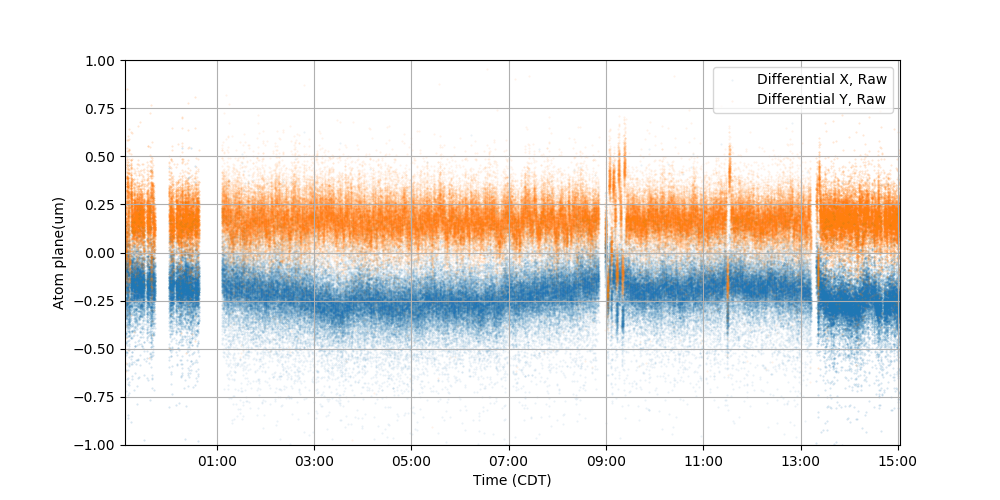

In [80]:
savefig=False
data_cutoff=0
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

ax.xaxis.set_major_formatter(xfmt)
data_to_plot=flatteneddata0-flatteneddata2-(flatteneddata0[0]-flatteneddata2[0])
ax.scatter(dates,data_to_plot,s=0.2,alpha=0.1,label='Differential X, Raw')
ax.set_xlim(dates[0],dates[-1])
ax.set_ylim(-1,1)

data_to_plot2=flatteneddata1-flatteneddata3-(flatteneddata1[0]-flatteneddata3[0])
ax.scatter(dates,data_to_plot2,s=0.2,alpha=0.1,label='Differential Y, Raw')
ax.grid()
ax.set_xlabel('Time (CDT)')
ax.set_ylabel('Atom plane(um)')
ax.legend()
if savefig:   
    plt.savefig('Alignment_over_night.png')

<IPython.core.display.Javascript object>


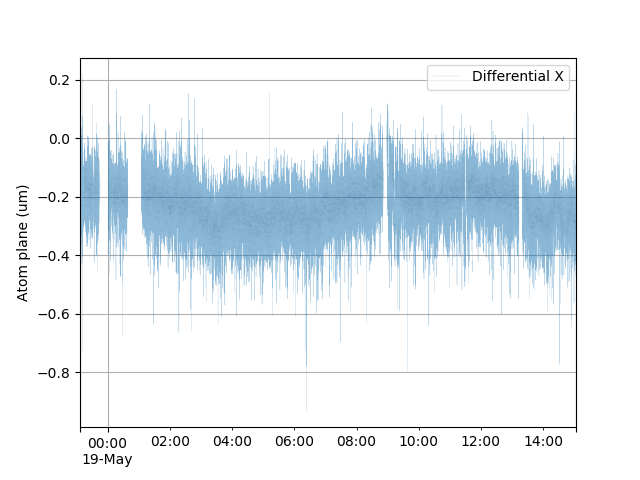

<IPython.core.display.Javascript object>


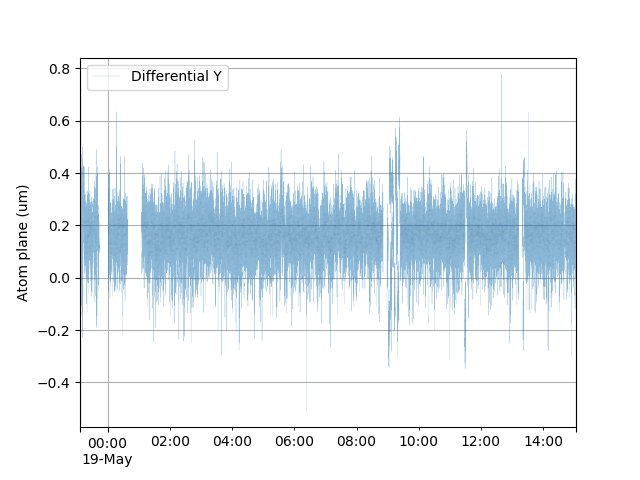

<IPython.core.display.Javascript object>


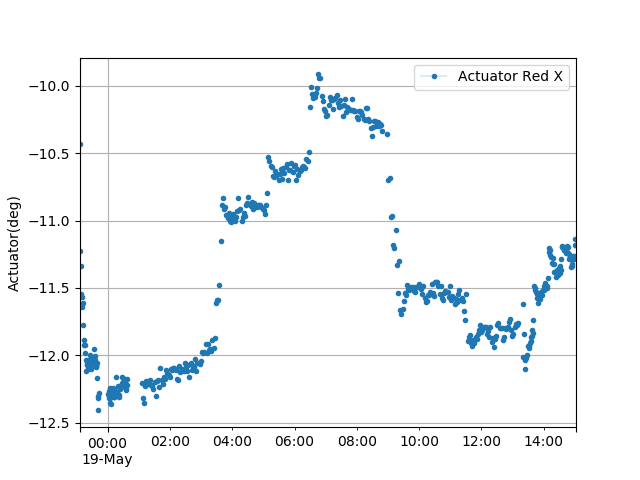

<IPython.core.display.Javascript object>


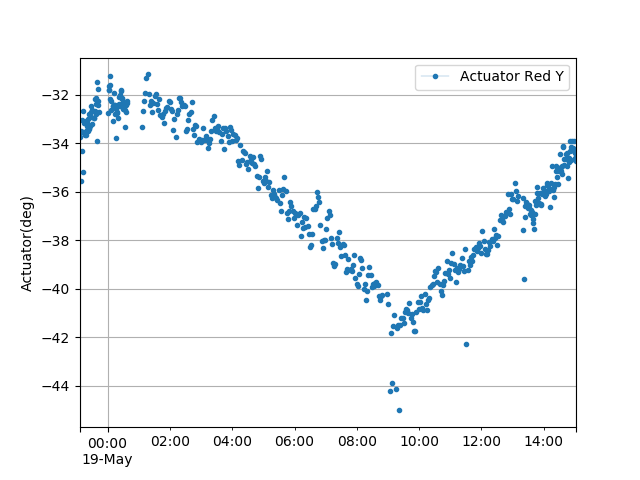

In [81]:
# Using Pandas
import pandas as pd
savefig=False
data_cutoff=0
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))

dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]
dates_iterations=[dt.datetime.fromtimestamp(ts) for ts in data['timestamp_iteration']]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

samplerate='1S'
offsetX=(flatteneddata0-flatteneddata2)[0]
offsetY=(flatteneddata1-flatteneddata3)[0]
df=pd.DataFrame({'Differential X': flatteneddata0-flatteneddata2-offsetX,
                 'Differential Y': flatteneddata1-flatteneddata3-offsetY,
                 'Red X': flatteneddata0,
                 'Red Y': flatteneddata1,
                 'FORT X': flatteneddata2,
                 'FORT Y': flatteneddata3,
                },index=dates)

df_actuators=pd.DataFrame({
                 'Actuator Red X':np.array(data['Red_X']),
                 'Actuator Red Y':np.array(data['Red_Y'])
                },index=dates_iterations)


## 
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Differential X'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

ax=data_to_plot2.plot(y=['Differential Y'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

data_to_plot3=df_actuators.resample(samplerate).mean()

ax=data_to_plot3.plot(y=['Actuator Red X'],alpha=1,lw=0.2,marker='.')
ax.set_ylabel('Actuator(deg)')
ax.grid()
ax.legend()

ax=data_to_plot3.plot(y=['Actuator Red Y'],alpha=1,lw=0.2,marker='.')
ax.set_ylabel('Actuator(deg)')
ax.grid()
ax.legend()

<IPython.core.display.Javascript object>


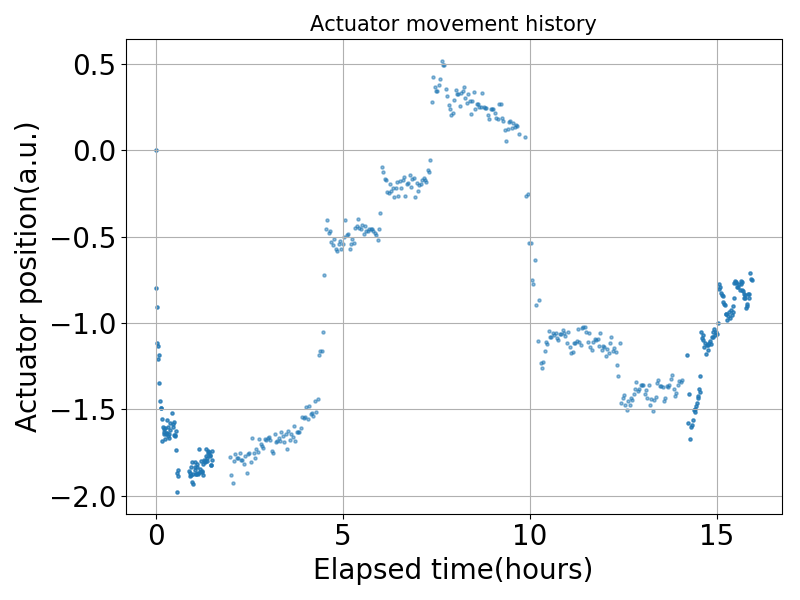

<IPython.core.display.Javascript object>


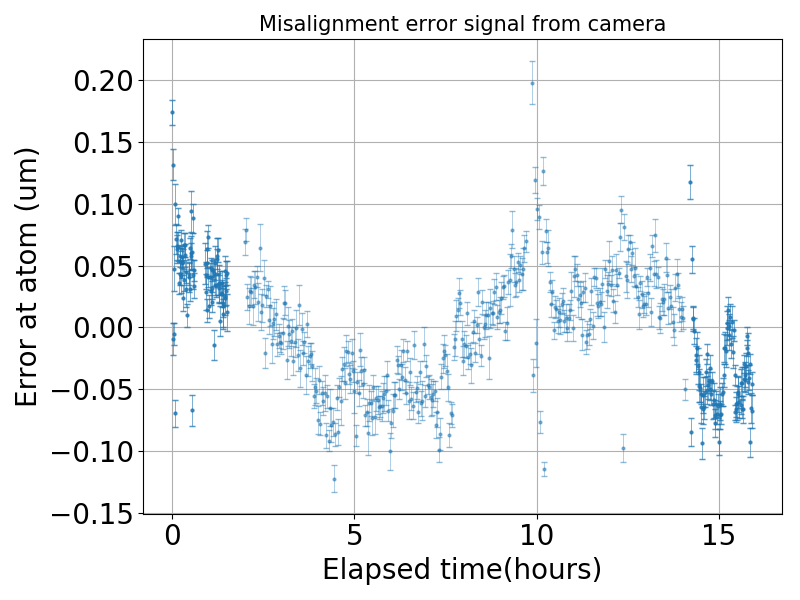

In [82]:
## Actuator Plot
savefig=False
actuator_x=np.array(data['Red_X'])
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_x-actuator_x[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator X History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

############ Camera error signal, X
camera_error_x=[]
camera_error_sigma_x=[]

samples=100
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_x.append(data[keylist[4]][i]['error_x']/calibration_factor)
        camera_error_sigma_x.append(data[keylist[4]][i]['sigma_x']/math.sqrt(samples))
    except:
        print i
        camera_error_x.append(np.nan)
        camera_error_sigma_x.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS X History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


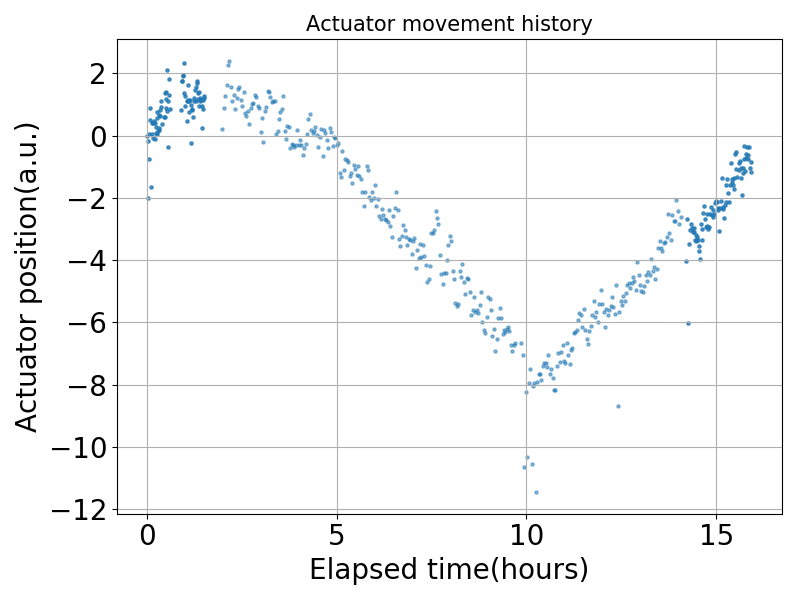

<IPython.core.display.Javascript object>


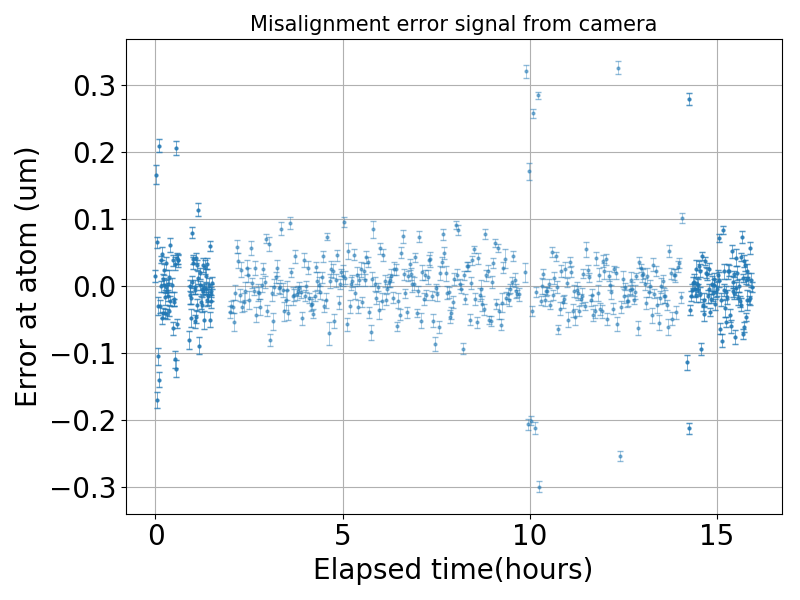

In [83]:
## Actuator Plot
savefig=False
actuator_y=np.array(data['Red_Y'])
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_y-actuator_y[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator Y History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

############ Camera error signal, Y
camera_error_y=[]
camera_error_sigma_y=[]

samples=100
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_y.append(data[keylist[4]][i]['error_y']/calibration_factor)
        camera_error_sigma_y.append(data[keylist[4]][i]['sigma_y']/math.sqrt(samples))
    except:
        print i
        camera_error_y.append(np.nan)
        camera_error_sigma_y.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_y,yerr=camera_error_sigma_y,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS Y History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

# Figuring out the dead region

<IPython.core.display.Javascript object>


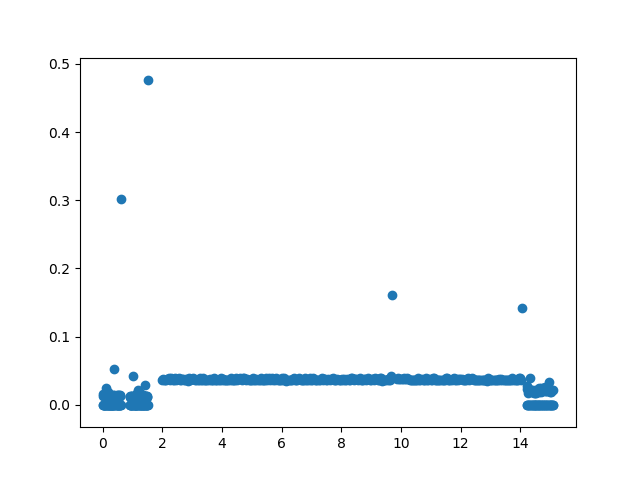

In [63]:
fig, ax= plt.subplots()
sorted_times=np.sort(elapsed_time_in_hours)
dead_times=sorted_times[1:]-sorted_times[0:-1]
ax.scatter(sorted_times[0:-1],dead_times)
threshold=2
dead_T=[]
dead_duration=[]
for i in range(0,len(dead_times)):
    if dead_times[i]>threshold:
        print 'T={}, duration of :{}'.format(sorted_times[0:-1][i],dead_times[i])
        dead_T.append(sorted_times[0:-1][i])
        dead_duration.append(dead_times[i])

<IPython.core.display.Javascript object>


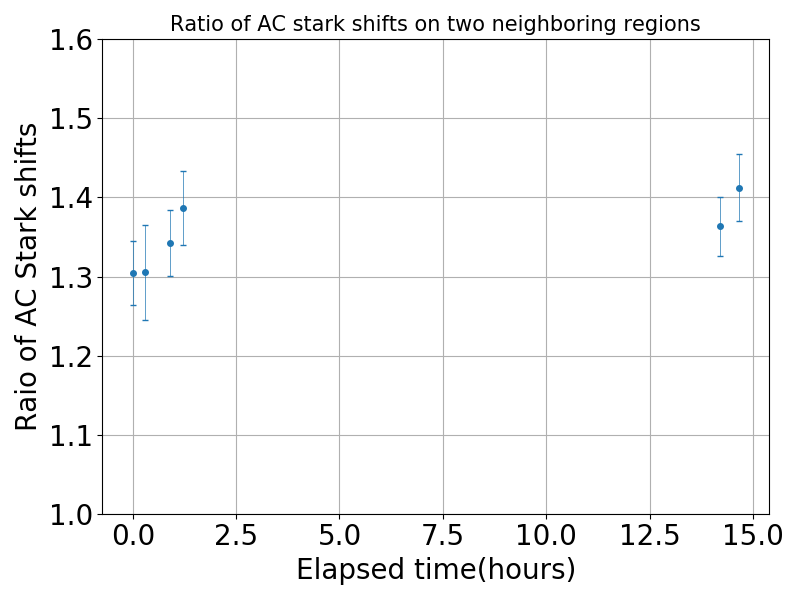

In [64]:
correction=0.7
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
# for i in range(0,len(dead_T)):
#     ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],1.1-0.3,1.1+0.3,alpha=0.1,color='r')
ax.set_ylim(1.3-0.3,1.3+0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()

# Insert room temperature history

<IPython.core.display.Javascript object>


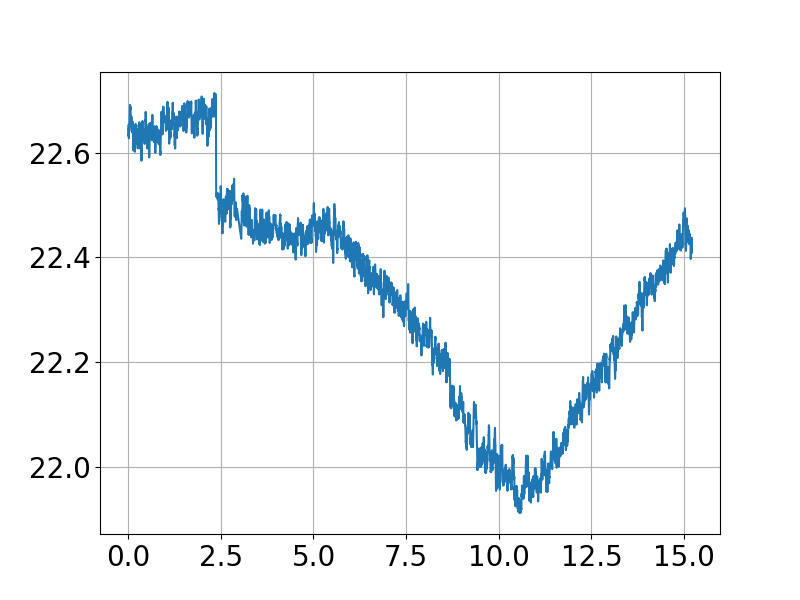

22.6327109524


In [70]:
from numpy import genfromtxt
my_data=genfromtxt('Rb_labtemperature.csv',delimiter=',')
temperatures_in_C=np.array(my_data[:,1]) # Selecting data from 2018-04-17 13:00, 30min interval
timestamps=np.array(my_data[:,0])/2**32
offset=temperatures_in_C[0]#np.mean(temperatures_in_C)

fig, ax=plt.subplots()
fig.set_size_inches(8,6)
ax.plot((timestamps-timestamps[0])/3600,temperatures_in_C)
ax.grid()
#ax.set_ylim(-1,1)
ax.tick_params(labelsize=20)

for i in range(0,len(dead_T)):
     ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],-0.4,0.4,alpha=0.1,color='r')

print temperatures_in_C[0]

In [48]:
my_data

array([[  6.55712007e+18,   2.26327110e+01,   3.34742380e+03],
       [  6.55712008e+18,   2.26325596e+01,   3.34744660e+03],
       [  6.55712016e+18,   2.26359802e+01,   3.34693150e+03],
       ..., 
       [  6.55735520e+18,   2.24339886e+01,   3.37750250e+03],
       [  6.55735521e+18,   2.24349951e+01,   3.37734940e+03],
       [  6.55735522e+18,   2.24367175e+01,   3.37708740e+03]])

<IPython.core.display.Javascript object>


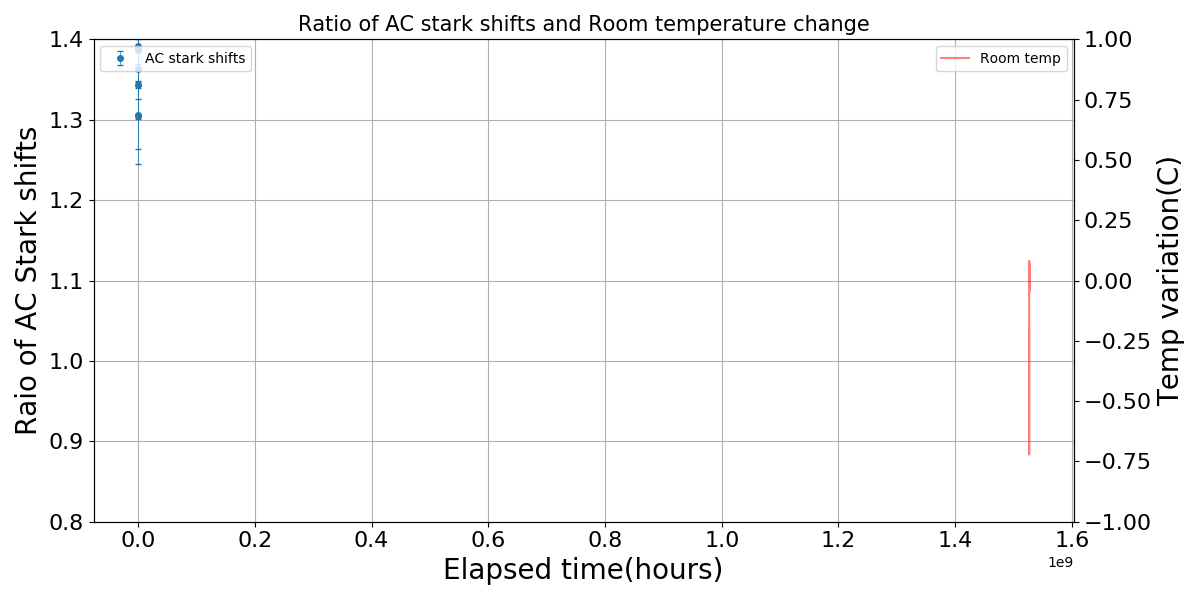

In [86]:
# Together!!
correction=0.7
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',label='AC stark shifts')
ax2=ax.twinx()
ax2.plot(timestamps,temperatures_in_C-offset,color='r',alpha=0.5,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax2.set_ylabel('Temp variation(C)',fontsize=20)
ax.set_title('Ratio of AC stark shifts and Room temperature change',fontsize=15)
for i in range(0,len(dead_T)):
    ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],1.1-0.3,1.1+0.3,alpha=0.1,color='gray')
ax.set_ylim(1.1-0.3,1.1+0.3)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylim(-1,1)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# filename='20180422_AC_starkshifts and temperature'
# plt.savefig(filename+'.png')
# plt.savefig(filename+'.pdf')
# plt.savefig(filename+'.eps')


<IPython.core.display.Javascript object>


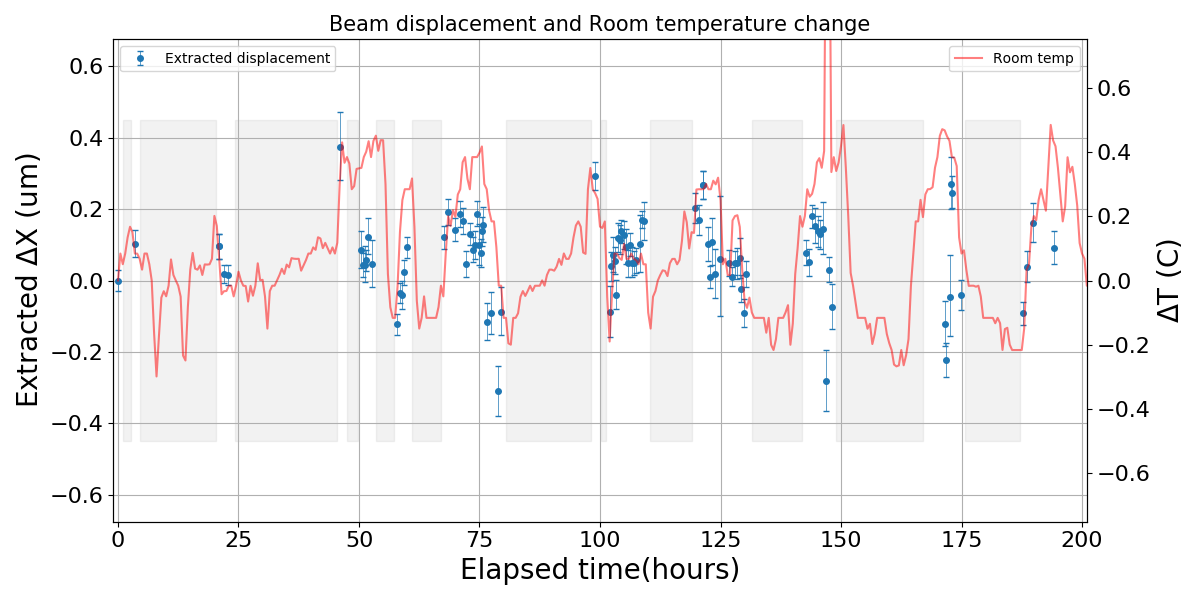

In [122]:

timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',label='Extracted displacement')
ax2=ax.twinx()
ax2.plot(timestamps,temperatures_in_C-offset,color='r',alpha=0.5,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Extracted $\Delta$X (um)',fontsize=20)
ax2.set_ylabel(r'$\Delta$T (C)',fontsize=20)
ax.set_title('Beam displacement and Room temperature change',fontsize=15)
for i in range(0,len(dead_T)):
    ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],-0.45,0.45,alpha=0.1,color='gray')
scaler=1.5
ax.set_ylim(scaler*-0.45,scaler*0.45)
ax2.set_ylim(scaler*-0.5,scaler*0.5)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
ax.set_xlim(-1,201)
filename='20180428_Extracted_horizontal_misalignment_and_Temperature'
savefig=True
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


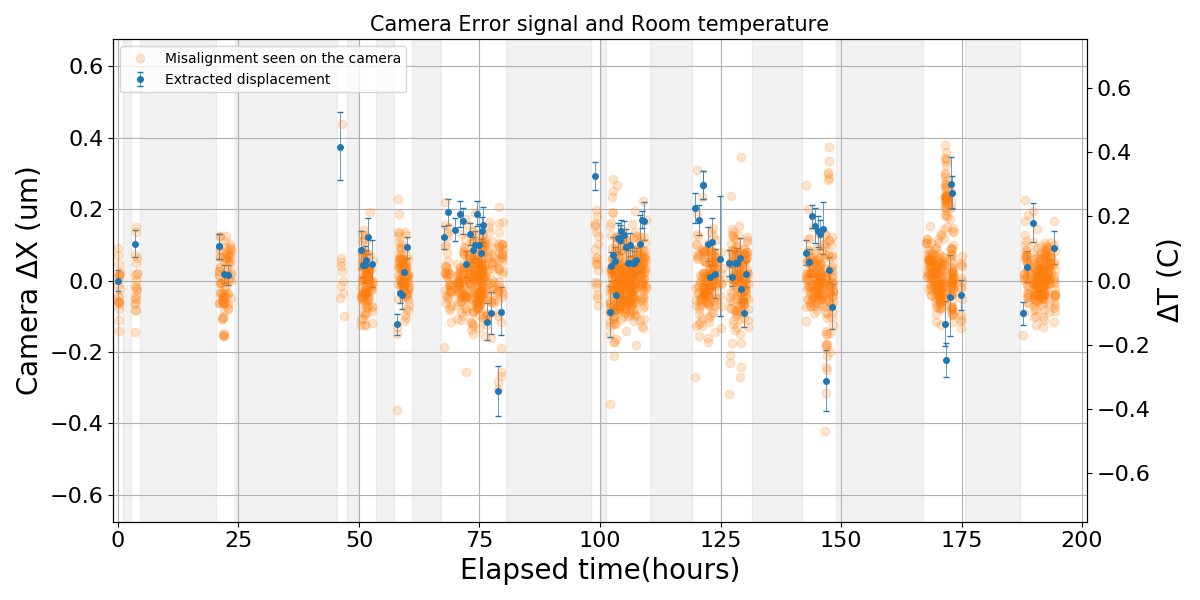

In [209]:
## Temperature and camera error signal plot
## Use pandas and resampling to plot them at similar time scale?
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',label='Extracted displacement')
ax.plot(elapsed_time_in_hours,camera_error_x,label='Misalignment seen on the camera',marker='o',linestyle='none',alpha=0.2)
ax2=ax.twinx()
#ax2.plot(timestamps,temperatures_in_C-offset,color='r',alpha=0.8,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Camera $\Delta$X (um)',fontsize=20)
ax2.set_ylabel(r'$\Delta$T (C)',fontsize=20)
ax.set_title('Camera Error signal and Room temperature',fontsize=15)
scaler=1.5
for i in range(0,len(dead_T)):
    ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],scaler*-0.45,scaler*0.45,alpha=0.1,color='gray')

ax.set_ylim(scaler*-0.45,scaler*0.45)
ax2.set_ylim(scaler*-0.5,scaler*0.5)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
ax.set_xlim(-1,201)
filename='20180428_Camera_and_Atom_comparison'
savefig=True
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

In [ ]:
## Temperature and camera error signal plot
## Use pandas and resampling to plot them at similar time scale?
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
#ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.1,lw=0.5,marker='o',markersize=4,linestyle='None',label='Extracted displacement')
#ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.5,lw=0.5,markersize=4,linestyle='None',label='Extracted displacement')
ax.plot(elapsed_time_in_hours,camera_error_x,label='Extracted displacement',marker='o',linestyle='none',alpha=0.2)
#ax.hexbin(elapsed_time_in_hours,camera_error_x,gridsize=(300,10),label='Extracted displacement')
#ax.hexbin(elapsed_time_in_hours,camera_error_x,gridsize=(300,10),label='Extracted displacement')
ax2=ax.twinx()
ax2.plot(timestamps,temperatures_in_C-offset,color='r',alpha=0.8,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Camera $\Delta$X (um)',fontsize=20)
ax2.set_ylabel(r'$\Delta$T (C)',fontsize=20)
ax.set_title('Camera Error signal and Room temperature',fontsize=15)
scaler=1.5
for i in range(0,len(dead_T)):
    ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],scaler*-0.45,scaler*0.45,alpha=0.1,color='gray')

ax.set_ylim(scaler*-0.45,scaler*0.45)
ax2.set_ylim(scaler*-0.5,scaler*0.5)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
ax.set_xlim(-1,201)
filename='20180428_camera_horizontal_misalignment_and_Temperature'
savefig=False
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


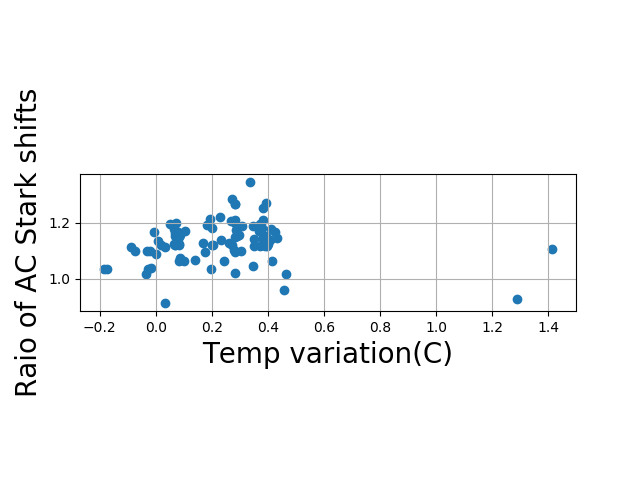

In [51]:
interpolated_temperature=np.interp(timediff,timestamps,temperatures_in_C-offset)
fig, ax=plt.subplots()
ax.scatter(interpolated_temperature,ratio_data)
ax.set_aspect('equal')
ax.set_xlabel('Temp variation(C)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.grid()

<IPython.core.display.Javascript object>


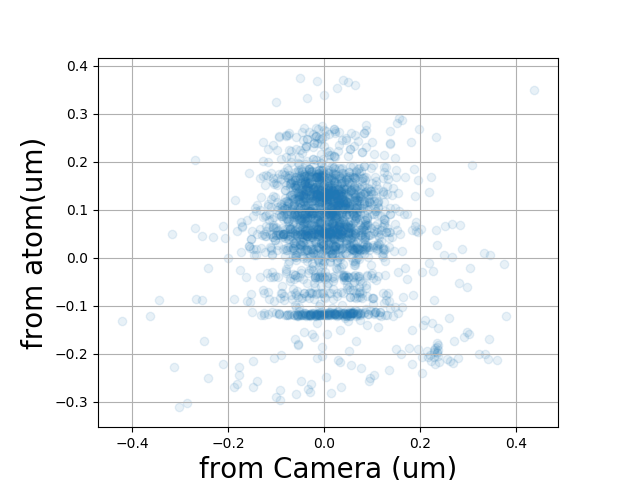

In [172]:
# Camera Error signal vs Atom signal
# elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x
time_offset=0
#interpolated_error_x=np.interp(timediff+time_offset,elapsed_time_in_hours,camera_error_x)
interpolated_atom_x=np.interp(elapsed_time_in_hours+time_offset,timediff,displacement_frombias)
fig, ax=plt.subplots()
#ax.hexbin(camera_error_x,interpolated_atom_x,gridsize=40)
#ax.scatter(camera_error_x,interpolated_atom_x,alpha=0.1)
ax.set_aspect('equal')
ax.set_xlabel('from Camera (um)',fontsize=20)
ax.set_ylabel('from atom(um)',fontsize=20)
ax.grid()
ax.set_aspect('equal')

In [154]:
np.size(elapsed_time_in_hours)

2195

In [126]:
timediff

array([   0.        ,    3.48471694,   20.94659722,   20.94659722,
         22.02374889,   22.83502472,   46.14175194,   50.43195417,
         50.84260028,   51.18150556,   51.51876861,   51.89722056,
         52.62958306,   57.91884361,   58.47059389,   58.96669083,
         59.43727583,   59.87217111,   67.66185556,   68.4693075 ,
         69.94930583,   70.91257583,   71.56578667,   72.24758389,
         72.94265833,   73.585415  ,   73.98553194,   74.47450361,
         74.86974083,   75.21645028,   75.52191667,   75.8017675 ,
         76.52271417,   77.30667389,   78.7948975 ,   79.47338528,
         98.91573222,  102.01844167,  102.33729306,  102.68075111,
        103.04679111,  103.39736528,  103.73350472,  104.14270861,
        104.44181667,  104.89870722,  105.32815   ,  105.78663028,
        106.17394333,  106.56550694,  106.95965389,  107.38826667,
        108.2555825 ,  108.67492139,  109.06880278,  119.80086333,
        120.55649056,  121.37411861,  121.37411861,  122.35684

# Allan deviation

In [87]:
from IPython.display import display, clear_output
# Allan 
tau_list=range(1,100)+range(101,1001,10)+range(1002,10002,100)+range(10003,80003,100)#+range(80004,100004,50)+range(100005,1000005,500)
samplerates=[]
for i in tau_list:
    samplerates.append('{}S'.format(i))
        
samplerate='1S'

var_list={}

original_resampled=df.resample(samplerate).mean()

for i in range(0,len(tau_list)):
    avg_samplerate=samplerates[i]
    tau=tau_list[i]
    clear_output()
    display('Tau: '+str(tau))
    try:
        downsampled=df.resample(avg_samplerate).mean() # Takes block-average for given time chuck size
        for key in downsampled:
            values=downsampled[key].values
            Xtau=values[1:]
            Xo=values[0:-1]
            var=np.nanmean(np.abs(Xtau-Xo))
            if i==0:
                var_list[key]=[]
            var_list[key].append(var)
    except:
        pass

'Tau: 79903'

<IPython.core.display.Javascript object>


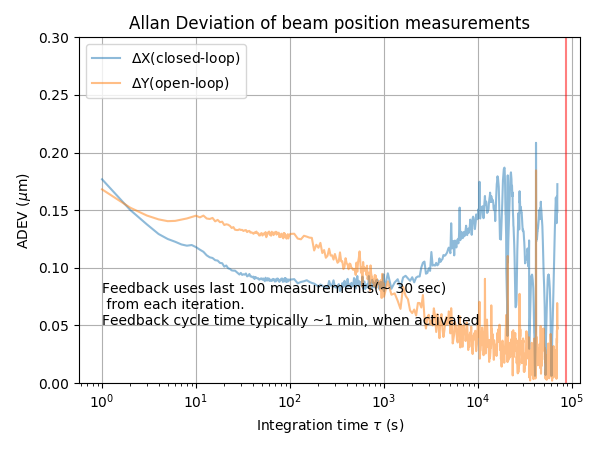

In [88]:
savefig=False
fig, ax = plt.subplots()
fig.set_size_inches(6,4.5)
#xdata=tau_lists
#for key in var_list:
#i=['Diff X(closed-loop)','Diff Y(open-loop)']
#for key in ['Differential X','Differential Y']:
ax.semilogx(tau_list, np.sqrt(0.5*np.array(var_list['Differential X'])),label=r'$\Delta$X(closed-loop)',alpha=0.5)
ax.semilogx(tau_list, np.sqrt(0.5*np.array(var_list['Differential Y'])),label=r'$\Delta$Y(open-loop)',alpha=0.5)
#ax.semilogx(tau_list, np.sqrt(Yvar_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Xvariance_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Yvariance_list),label='Diff Y',alpha=0.5)
ax.legend()
plt.axvline(x=86400,color='red',alpha=0.5)
#ax.set_xlim(1,)
ax.set_title('Allan Deviation of beam position measurements')
ax.set_xlabel(r'Integration time $\tau$ (s)')
ax.set_ylabel(r'ADEV ($\mu$m)')
ax.text(10**0,0.05,'Feedback uses last 100 measurements(~ 30 sec)\n from each iteration.\nFeedback cycle time typically ~ 2 min, when activated')
ax.text(10**5,0.37,'1 day')
#ax.axvline(x=60,color='k',alpha=0.3)
ax.set_ylim(0.0,0.3)
ax.grid()
plt.tight_layout()
savefig=True
filename='20180428_AllanDeviation'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')


In [26]:
25*0.3

7.5

In [28]:
200*0.3

60.0

In [39]:
from random import uniform
import time
from IPython.display import display, clear_output

def black_box():
    i = 1
    while True:
        clear_output()
        display('Iteration '+str(i)+' Score: '+str(uniform(0, 1)))
        time.sleep(1)
        i += 1

In [41]:
black_box()

'Iteration 11 Score: 0.549605354165'

KeyboardInterrupt: 